<a href="https://colab.research.google.com/github/Korniev/Machine-Learning-projects/blob/main/Image_Classification/image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import libraries

In [ ]:
import cv2
import pandas as pd
import numpy as np
import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Dropout, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator
from keras.datasets import cifar100
from keras.utils import to_categorical
from keras.applications import ResNet50, EfficientNetB0, MobileNetV2
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

Downloading the CIFAR-100 dataset

In [ ]:
(x_train, y_train), (x_test, y_test) = cifar100.load_data()

In [ ]:
print(x_train.shape,y_train.shape)
print(x_test.shape,y_test.shape)

(50000, 32, 32, 3) (50000, 1)
(10000, 32, 32, 3) (10000, 1)


**Resizing images**

Let's normalise our data

In [ ]:
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

Convert labels to a category format

In [ ]:
y_train = to_categorical(y_train, 100)
y_test = to_categorical(y_test, 100)

Setting up the image generator for the CIFAR-100 dataset with increasing image size

In [ ]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2
)

datagen.fit(x_train)


Download the basic EfficientNetB0 model without the top layer

In [ ]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

In [ ]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 38, 38, 3)            0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 16, 16, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 16, 16, 64)           256       ['conv1_conv[0][0]']          
 on)                                                                                       

Add new layers

In [ ]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(100, activation='softmax')(x)

Now we can create a new model

In [ ]:
model = Model(inputs=base_model.input, outputs=predictions)

We can try to frost base layers

In [ ]:
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 38, 38, 3)            0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 16, 16, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 16, 16, 64)           256       ['conv1_conv[0][0]']          
 on)                                                                                          

Let's compile our new model

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Now we can train our new model

In [ ]:
history = model.fit(datagen.flow(x_train, y_train, batch_size=128), epochs=5, validation_data=(x_test, y_test))

Epoch 1/5
391/391 [==============================] - 48s 101ms/step - loss: 4.3550 - accuracy: 0.0535 - val_loss: 4.8114 - val_accuracy: 0.0166
Epoch 2/5
391/391 [==============================] - 38s 96ms/step - loss: 4.1035 - accuracy: 0.0829 - val_loss: 4.8364 - val_accuracy: 0.0210
Epoch 3/5
391/391 [==============================] - 39s 100ms/step - loss: 4.0201 - accuracy: 0.0948 - val_loss: 5.1006 - val_accuracy: 0.0226
Epoch 4/5
391/391 [==============================] - 39s 100ms/step - loss: 3.9569 - accuracy: 0.1039 - val_loss: 5.1567 - val_accuracy: 0.0287
Epoch 5/5
391/391 [==============================] - 40s 102ms/step - loss: 3.9111 - accuracy: 0.1108 - val_loss: 5.1883 - val_accuracy: 0.0237


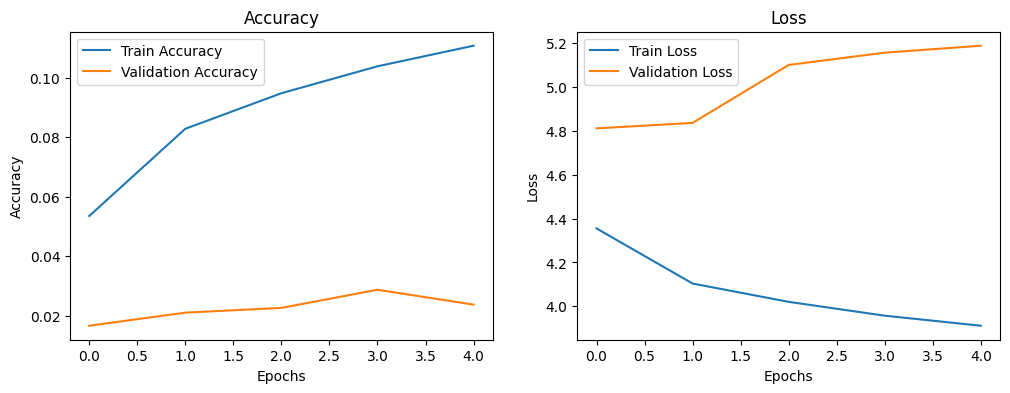

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

Defrost all layers of the base model for fine-tuning

In [ ]:
for layer in base_model.layers:
    layer.trainable = True

Recompile the model

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

Additional training of the model

In [ ]:
history = model.fit(datagen.flow(x_train, y_train, batch_size=128), epochs=5, validation_data=(x_test, y_test))

Epoch 1/5
391/391 [==============================] - 83s 123ms/step - loss: 5.9117 - accuracy: 0.0314 - val_loss: 421.5716 - val_accuracy: 0.0099
Epoch 2/5
391/391 [==============================] - 45s 114ms/step - loss: 4.3278 - accuracy: 0.0613 - val_loss: 24.2875 - val_accuracy: 0.0323
Epoch 3/5
391/391 [==============================] - 46s 119ms/step - loss: 4.0344 - accuracy: 0.0988 - val_loss: 7.7152 - val_accuracy: 0.0517
Epoch 4/5
391/391 [==============================] - 44s 112ms/step - loss: 3.8353 - accuracy: 0.1261 - val_loss: 5.7463 - val_accuracy: 0.0613
Epoch 5/5
391/391 [==============================] - 46s 117ms/step - loss: 3.6462 - accuracy: 0.1529 - val_loss: 5.7524 - val_accuracy: 0.0679


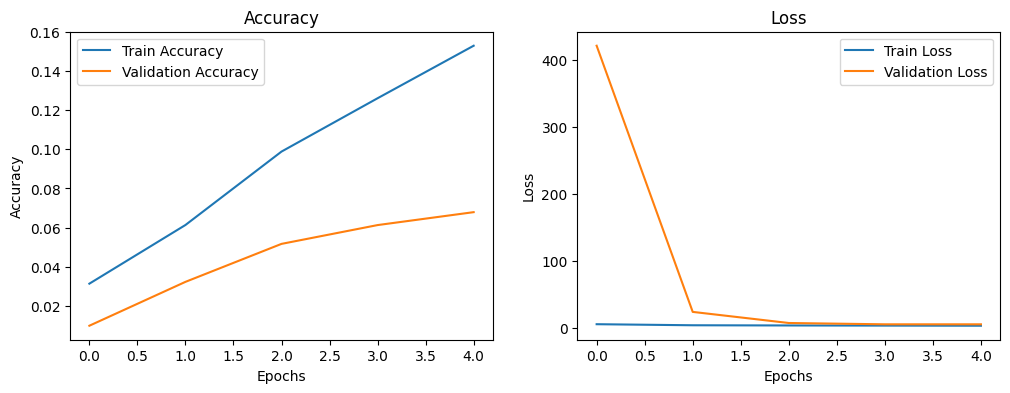

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

Evaluation of the model

In [ ]:
scores = model.evaluate(x_test, y_test, verbose=1)
print(f"Test accuracy: {scores[1]*100:.2f}%")

313/313 [==============================] - 3s 10ms/step - loss: 5.7524 - accuracy: 0.0679
Test accuracy: 6.79%
